In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

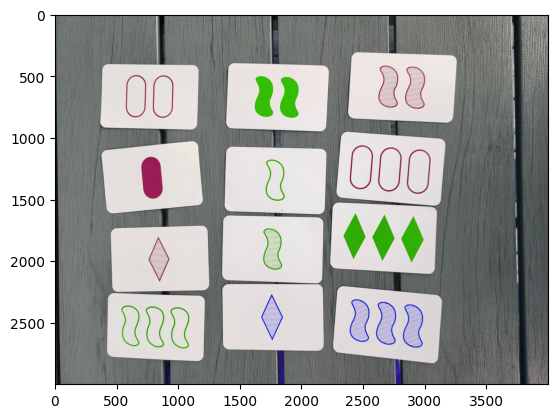

In [2]:
img = cv2.imread("../samples/sample_3.jpg")
plt.imshow(img)

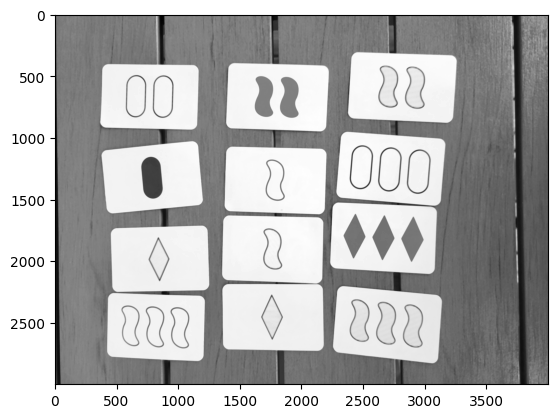

In [3]:
sep_blur = cv2.medianBlur(img, ksize=13)
sep_blur_gray = cv2.cvtColor(sep_blur, cv2.COLOR_BGR2GRAY)
plt.imshow(sep_blur_gray, cmap="gray")

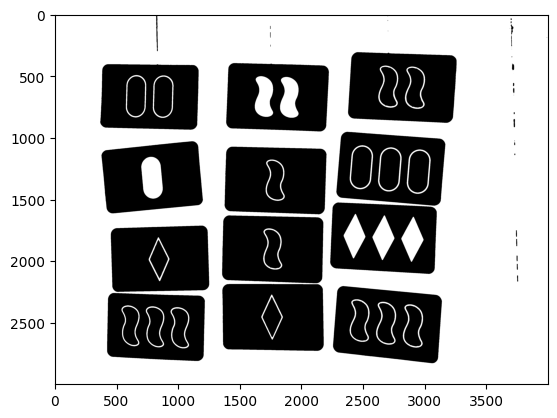

In [4]:
ret, sep_blur_bin = cv2.threshold(sep_blur_gray, 170, 255, cv2.THRESH_BINARY_INV)
plt.imshow(sep_blur_bin, cmap="gray")

In [5]:
contours, hierarchy = cv2.findContours(sep_blur_bin, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)

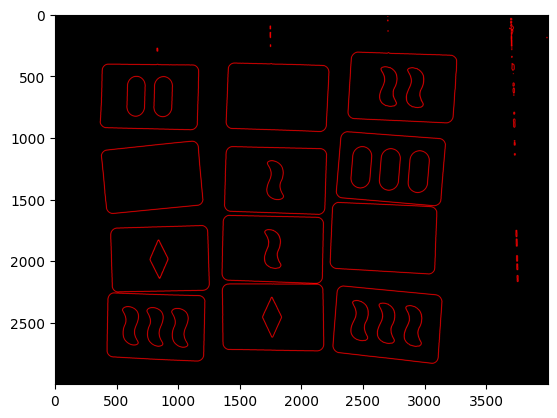

In [6]:
external = np.zeros(img.shape)

for i in range(len(contours)):
    #external contour
    if hierarchy[0][i][3] != -1:
        cv2.drawContours(external, contours, i, 1., 5)

plt.imshow(external, cmap='gray')

In [7]:
index_sort = sorted(range(len(contours)), key=lambda i : cv2.contourArea(contours[i]),reverse=True)

In [8]:
# Otherwise, initialize empty sorted contour and hierarchy lists
cnts_sort = []
hier_sort = []
cnt_is_card = np.zeros(len(contours),dtype=int)    

In [9]:
# Fill empty lists with sorted contour and sorted hierarchy. Now,
# the indices of the contour list still correspond with those of
# the hierarchy list. The hierarchy array can be used to check if
# the contours have parents or not.
for i in index_sort:
    cnts_sort.append(contours[i])
    hier_sort.append(hierarchy[0][i])

In [10]:
size = cv2.contourArea(cnts_sort[1]) 
(size < 1000000) and (size > 250000)

True

In [11]:
peri = cv2.arcLength(cnts_sort[8], True)
approx = cv2.approxPolyDP(cnts_sort[8], 0.075*peri, True)
approx = np.squeeze(approx, axis = 1)
approx

array([[1395, 1101],
       [2177, 1098],
       [2182, 1597],
       [1402, 1593]], dtype=int32)

In [12]:
s = np.sum(approx, axis=1)
topLeft = approx[np.argmin(s)]
bottomRight = approx[np.argmax(s)]
topLeft, bottomRight

(array([1395, 1101], dtype=int32), array([2182, 1597], dtype=int32))

In [13]:
d = np.diff(approx, axis = -1)
topRight = approx[np.argmax(d)]
bottomLeft = approx[np.argmin(d)]
topRight, bottomLeft

(array([1402, 1593], dtype=int32), array([2177, 1098], dtype=int32))

In [14]:
np.sqrt(np.sum(np.square(topLeft-bottomLeft)))

np.float64(782.0057544545308)

In [15]:
# UpperLeft, UpperRight, LowerRight, LowerLeft
approx_sorted = np.array([topLeft, bottomLeft, bottomRight, topRight], np.int32)
approx_sorted

array([[1395, 1101],
       [2177, 1098],
       [2182, 1597],
       [1402, 1593]], dtype=int32)

In [16]:
np.min(approx_sorted[:,1])

np.int32(1098)

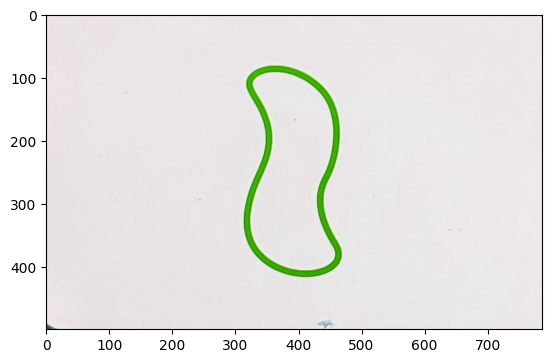

In [17]:
tmp_img = img[np.min(approx_sorted[:,1]):np.max(approx_sorted[:,1]),
              np.min(approx_sorted[:,0]):np.max(approx_sorted[:,0])]
plt.imshow(tmp_img)

In [18]:
# Determine which of the contours are cards by applying the
# following criteria: 1) Smaller area than the maximum card size,
# 2), bigger area than the minimum card size, 3) have no parents,
# and 4) have four corners

boundingBox = []
Card = []
maxWidth = 200
maxHeight = 300

for i in range(len(cnts_sort)):
    size = cv2.contourArea(cnts_sort[i])
    peri = cv2.arcLength(cnts_sort[i],True)
    approx = cv2.approxPolyDP(cnts_sort[i],0.075*peri,True)
        
    if ((size < 1000000) and (size > 250000)
        and (hier_sort[i][3] != -1) and (len(approx) == 4)):
        cnt_is_card[i] = 1
        s = np.sum(approx, axis=2)
        topLeft = approx[np.argmin(s)]
        bottomRight = approx[np.argmax(s)]
        d = np.diff(approx, axis = -1)
        topRight = approx[np.argmax(d)]
        bottomLeft = approx[np.argmin(d)]
        src = np.array([topLeft, bottomLeft, bottomRight, topRight], np.float32)
        dst = np.array([[0,0],[maxWidth-1,0],[maxWidth-1,maxHeight-1],[0, maxHeight-1]], np.float32)
        M = cv2.getPerspectiveTransform(src, dst)
        warped_img = cv2.warpPerspective(img, M, (maxWidth, maxHeight))
        Card.append(warped_img[10:290,10:190])


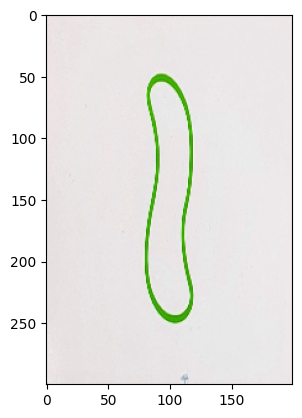

In [19]:
# Create destination array, calculate perspective transform matrix,
# and warp card image
dst = np.array([[0,0],[maxWidth-1,0],[maxWidth-1,maxHeight-1],[0, maxHeight-1]], np.float32)
src = approx_sorted.astype(np.float32)
M = cv2.getPerspectiveTransform(src, dst)
warp = cv2.warpPerspective(img, M, (maxWidth, maxHeight))

plt.imshow(warp)

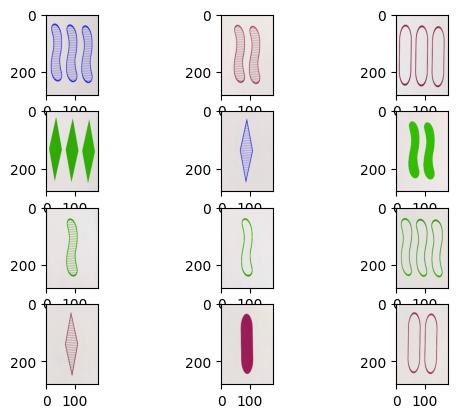

In [20]:
x, y = 3, 4
figure, axis = plt.subplots(y, x)
for i in range(y):
    for j in range(x):
        axis[i, j].imshow(Card[i*x+j])
plt.show()

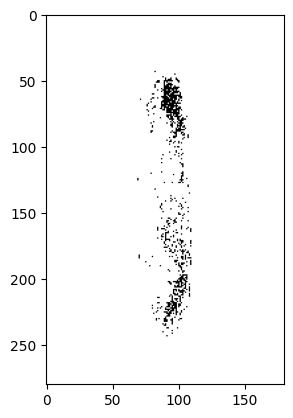

In [370]:
card_n = Card[10]

card_0_hsv = cv2.cvtColor(card_n, cv2.COLOR_RGB2HLS)
card_0_hue, _, card_0_gray = cv2.split(card_0_hsv)
#card_0_gray = cv2.cvtColor(card_n, cv2.COLOR_BGR2GRAY)
_, card_0_bin = cv2.threshold(card_0_gray, 180, 255, cv2.THRESH_BINARY_INV)
contours, hierarchy = cv2.findContours(card_0_bin, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

plt.imshow(card_0_bin, cmap='gray')


In [371]:
M = cv2.moments(contours[0])

In [372]:
cx = int(M['m10']/M['m00'])
cy = int(M['m01']/M['m00'])

cv2.countNonZero(card_0_bin[cy-10:cy+10, cx-20:cx+20])


773

In [373]:
card_0_masked = cv2.bitwise_and(card_0_hsv, card_0_hsv, mask = card_0_bin)
card_0_hist = cv2.calcHist([card_0_hsv], channels = [0], mask = card_0_bin, histSize =[32], ranges  = [0, 255])
np.argmax(card_0_hist)

np.int64(1)

In [374]:
class ShapeDetector:
    def __init__(self):
        pass
    def detect(self, card):
        card_hls = cv2.cvtColor(card, cv2.COLOR_RGB2HLS)
        card_hue, card_gray, _ = cv2.split(card_hls)
        #card_0_gray = cv2.cvtColor(card, cv2.COLOR_BGR2GRAY)
        _, card_bin = cv2.threshold(card_gray, 180, 255, cv2.THRESH_BINARY_INV)
        contours, hierarchy = cv2.findContours(card_bin, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        
        card_masked = cv2.bitwise_and(card_hls, card_hls, mask = card_bin)
        card_hist = cv2.calcHist([card_hls], channels = [0], mask = card_bin, histSize =[32], ranges  = [0, 255])
        c_val = np.argmax(card_hist)

        if c_val < 10: color = "green"
        elif c_val < 18: color = "blue"
        else: color = "red"

        result = ""
        
        for c in contours: 
            if cv2.contourArea(c) > 800: 
                # initialize the shape name and approximate the contour
                shape = "unidentified"
                epsilon = 0.02*cv2.arcLength(c,True)
                approx = cv2.approxPolyDP(c,epsilon,True)
                M = cv2.moments(c)
                cx = int(M['m10']/M['m00'])
                cy = int(M['m01']/M['m00'])
                n_white = cv2.countNonZero(card_bin[cy-10:cy+10, cx-20:cx+20])
                if n_white < 10: 
                    shade = "empty"
                elif n_white < 500:
                    shade = "dashed"
                else: 
                    shade = "full"
                if not cv2.isContourConvex(approx):
                    shape = "snake"
                elif len(approx) == 4:
                    shape = "diamond"
                else: 
                    shape = "pill"
                # return the name of the shape
                result = result + color + " " + shade + " " + shape + "\n"
        return result

In [375]:
sd = ShapeDetector()

for i, card_i in enumerate(Card):
    print(f'Card {i}')
    shape = sd.detect(card_i)
    print(shape)
    print()

Card 0
blue dashed pill
blue dashed pill
blue dashed pill


Card 1
red dashed pill
red dashed pill


Card 2
red dashed pill
red dashed pill
red dashed pill


Card 3
green full diamond
green full diamond
green full diamond


Card 4
blue dashed diamond


Card 5
green full pill
green full pill


Card 6
green dashed pill


Card 7
green dashed pill


Card 8
green dashed pill
green dashed pill
green dashed pill


Card 9
red dashed diamond


Card 10
red full pill


Card 11
red dashed pill
red dashed pill




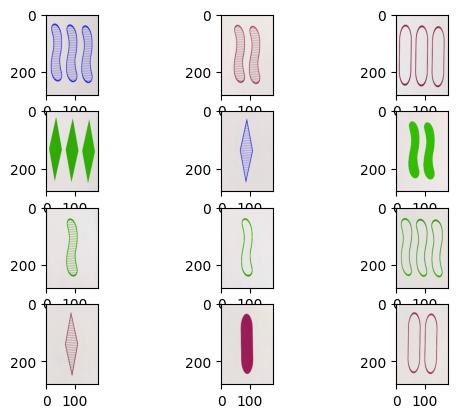

In [376]:
x, y = 3, 4
figure, axis = plt.subplots(y, x)
for i in range(y):
    for j in range(x):
        axis[i, j].imshow(Card[i*x+j])
plt.show()